In [55]:
# !pip install openai azure-identity azure-ai-documentintelligence

# Adjusting size of image

In [ ]:
import os
from PIL import Image

DOCUMENT_INTELLIGENCE_LIMIT = 1024 * 1024 * 10

class ImageSizeReducer:
    def __init__(self, start_quality=95, max_size=DOCUMENT_INTELLIGENCE_LIMIT):
        self.max_size = max_size
        self.start_quality = start_quality

    def resize_image(self, image_path):
        current_size = os.stat(image_path).st_size
        if current_size < self.max_size:
            return image_path
        quality = self.start_quality
        image = Image.open(image_path)
        while current_size >= self.max_size:
            image.save(image_path, optimize=True, quality=quality)
            current_size = os.stat(image_path).st_size
            quality -= 1

        return image_path

# Extracting figures

In [ ]:
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.core.credentials import AzureKeyCredential
from PIL import Image, ImageOps
from enum import Enum
import numpy as np
import base64

ENDPOINT = "https://<YOUR-DI-SERVICE-NAME>.cognitiveservices.azure.com/"
KEY = "<YOUR-DI-SERVICE-KEY>"


class BoundingBoxType(Enum):
    FIGURE = "figure"
    PARAGRAPH = "paragraph"
    LINE = "line"

class BoundingBox:
    def __init__(self, bounding_box, type: BoundingBoxType, angle, old_image_size, new_image_size):
        self.type = type
        points = np.array(bounding_box).reshape(4, 2)
        rotated_points = self.rotate_points(points, angle, old_image_size, new_image_size)
        self.bounding_box = rotated_points.flatten()
        # PIL params
        self.left, self.top, self.right, self.bottom = self.transform_bounding_box(self.bounding_box)

    @staticmethod
    def transform_bounding_box(bounding_box):
        left = min(bounding_box[0], bounding_box[6])
        top = min(bounding_box[1], bounding_box[3])
        right = max(bounding_box[2], bounding_box[4])
        bottom = max(bounding_box[5], bounding_box[7])
        return left, top, right, bottom

    @staticmethod
    def check_if_bounding_boxes_overlap(bounding_box1, bounding_box2):
        return (
            bounding_box2.top<=bounding_box1.top<=bounding_box2.bottom or bounding_box1.top<=bounding_box2.top<=bounding_box1.bottom) and (
            bounding_box2.left<=bounding_box1.left<=bounding_box2.right or bounding_box1.left<=bounding_box2.left<=bounding_box1.right)

    @staticmethod
    def extend_bounding_box(bounding_box, value):
        bounding_box.left -= value
        bounding_box.right += value
        bounding_box.top -= value
        bounding_box.bottom += value

        return bounding_box

    @staticmethod
    def extend_figure_bounding_box(figure_bounding_box, overlapping_paragraph_bounding_boxes):
        if figure_bounding_box.type != BoundingBoxType.FIGURE:
            raise ValueError("Figure bounding box must be of type FIGURE")
        if not all(b.type == BoundingBoxType.PARAGRAPH for b in overlapping_paragraph_bounding_boxes):
            raise ValueError("All text bounding boxes must be of type PARAGRAPH")

        for paragraph_bounding_box in overlapping_paragraph_bounding_boxes:
            figure_bounding_box.top = min(figure_bounding_box.top, paragraph_bounding_box.top)
            figure_bounding_box.bottom = max(figure_bounding_box.bottom, paragraph_bounding_box.bottom)
            figure_bounding_box.left = min(figure_bounding_box.left, paragraph_bounding_box.left)
            figure_bounding_box.right = max(figure_bounding_box.right, paragraph_bounding_box.right)

        return figure_bounding_box

    @staticmethod
    def rotate_points(points, angle, old_image_size, new_image_size):
        def rotate(p, degrees=0):
            angle = np.deg2rad(degrees)
            R = np.array([[np.cos(-angle), -np.sin(-angle)],
                        [np.sin(-angle),  np.cos(-angle)]])
            result = (R @ p.T).T
            return result
        center = (old_image_size[0]/2, old_image_size[1]/2)
        points = points - center
        points = rotate(points, degrees=angle)
        points = points + center
        bias = np.array([(new_image_size[0] - old_image_size[0])//2, (new_image_size[1] - old_image_size[1])//2])
        points = points + bias
        return points


class FigureExtractor:

    def __init__(self, endpoint, key, text_height_multiplier=3):
        self.endpoint = endpoint
        self.key = key
        self.document_intelligence_client = DocumentIntelligenceClient(
            endpoint=self.endpoint, credential=AzureKeyCredential(self.key)
        )
        self.text_height_multiplier = text_height_multiplier

    @staticmethod
    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")

    def get_result(self, image_path):
        base64_image = self.encode_image(image_path)
        poller = self.document_intelligence_client.begin_analyze_document(
            "prebuilt-layout", {"base64Source": base64_image}
        )
        result = poller.result()
        return result

    @staticmethod
    def read_image(image_path):
        image = Image.open(image_path)
        image = ImageOps.exif_transpose(image)
        return image

    @staticmethod
    def get_figures(result, angle, old_image_size, new_image_size):
        figures = []
        for figure in result.figures:
            figure = BoundingBox(figure["boundingRegions"][0]["polygon"], BoundingBoxType.FIGURE, angle, old_image_size, new_image_size)
            figures.append(figure)
        return figures

    @staticmethod
    def get_paragraphs(result, angle, old_image_size, new_image_size):
        paragraphs = []
        for paragraph in result.paragraphs:
            paragraph = BoundingBox(paragraph["boundingRegions"][0]["polygon"], BoundingBoxType.PARAGRAPH, angle, old_image_size, new_image_size)
            paragraphs.append(paragraph)
        return paragraphs

    @staticmethod
    def get_line_height(result, angle, old_image_size, new_image_size):
        line_height = float('inf')
        for line in result.pages[0].lines:
            line = BoundingBox(line["polygon"], BoundingBoxType.LINE, angle, old_image_size, new_image_size)
            line_height = min(line_height, line.bottom - line.top)
        if line_height == float('inf'):
            line_height = 10
        return line_height

    @staticmethod
    def cut_off_figure_from_image(image, figure):
        return image.crop((figure.left, figure.top, figure.right, figure.bottom))


    def extract_figures(self, image_path):
        result = self.get_result(image_path)
        angle = result.pages[0].angle
        image = self.read_image(image_path)
        rotated_image = image.rotate(angle, expand=True)

        figures = self.get_figures(result, angle, image.size, rotated_image.size)
        paragraphs = self.get_paragraphs(result, angle, image.size, rotated_image.size)
        line_height = self.get_line_height(result, angle, image.size, rotated_image.size)
        extended_figures = []
        for figure in figures:
            figure = BoundingBox.extend_bounding_box(figure, line_height * self.text_height_multiplier)
            overlapping_paragraphs = [p for p in paragraphs if BoundingBox.check_if_bounding_boxes_overlap(figure, p)]
            extended_figure = BoundingBox.extend_figure_bounding_box(figure, overlapping_paragraphs)
            extended_figures.append(extended_figure)

        cropped_images = []
        for figure in extended_figures:
            cropped_image = self.cut_off_figure_from_image(rotated_image, figure)
            cropped_images.append(cropped_image)

        return cropped_images

In [ ]:
figure_extractor = FigureExtractor(key=KEY, endpoint=ENDPOINT)
image_path = "data/rotated_test.jpg"

figures = figure_extractor.extract_figures(image_path)


line_height 38.960136300458544


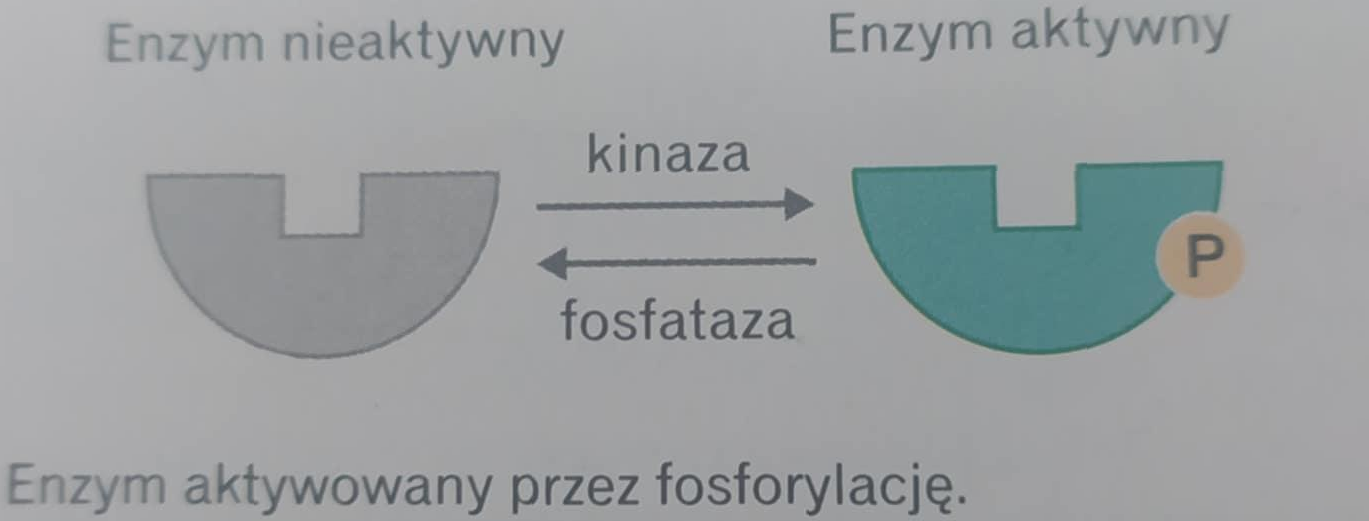

In [13]:
figures[0]

# Create filename

In [35]:
import base64
from openai import OpenAI
from io import BytesIO

MODEL = "gpt-5-mini"

class FilenameGenerator:
    prompt = """
Otrzymasz zdjęcie strony z Vademecuum Biologicznego. Strona zawiera tekst oraz przede wszystkim ilustrację.

Nazwij ilustrację obecną na zdjęciu, bądź jak najbardziej zwięzły - wytworzona nazwa ma być nazwą pliku pozwalającą szybko namierzyć odpowiednią grafikę w obrębie jednego działu. 
Użyj maksymalnie 5 słów. Zwróć tylko nazwę, bez żadnych dodatkowych informacji, a spacje zamień na podkreślenie.

Przykłady: 
Enzymy_aktywowane_przez_fosforylację
Fotosystem
Cykl_Krebsa
"""
    def __init__(self, model=MODEL):
        self.client = OpenAI()
        self.model = model

    @staticmethod
    def encode_image_file(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")

    @staticmethod
    def encode_PIL_image(image):
        with BytesIO() as output:
            image.save(output, format="JPEG")
            return base64.b64encode(output.getvalue()).decode("utf-8")

    
    def generate_filename(self, image_path = None, image = None):
        if image_path is not None:
            base64_image = self.encode_image_file(image_path)
        elif image is not None:
            base64_image = self.encode_PIL_image(image)
        else:
            raise ValueError("Either image_path or image must be provided")

        response = self.client.responses.create(
            model=self.model,
            input=[
                {
                    "role": "user",
                    "content": [
                        { "type": "input_text", "text": self.prompt },
                        {
                            "type": "input_image",
                            "image_url": f"data:image/jpeg;base64,{base64_image}",
                        },
                    ],
                }
            ]
        )
        return response.output_text


In [36]:
filaname_generator = FilenameGenerator()

response = filaname_generator.generate_filename(image=figures[0])
response

'Enzym_aktywowany_przez_fosforylację'